# xgboostを用いて、スプライスされやすい領域とそうでない領域の配列の学習を行う

**目的:**<br>
スプライシングを受けやすいイントロン領域とそうではないイントロン領域の二群に分割する<br>
各イントロンの両側n塩基の塩基配列を取得し、学習データとする<br>
教師あり学習であるXGBoostアルゴリズムを用いて、この二群のを分離させるような特徴的な塩基配列部位を同定する<br>
<br>

**略語**<br>
HAVSR: highly variable alternatively spliced<br>
LAVSR: Lowly variable alternatively spliced<br><br>

**注意点:**<br>
XGBClassifierのインスタンスおよびtrain_test_split関数のrandom stateを変更すると結果が異なる


## 準備

In [41]:
# オリジナルモジュールのインポート
from lib.introngap import PileUp
from lib.gbkparse import Seq_count

# モジュールのインポート
import itertools
import logomaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [42]:
# クラスのインスタンス化
gbk = Seq_count()

# gbkファイルの読み込み
gbk.read_gbk('../data/gbk/human_ttn.gb')

デフォルト値として、最もエクソンの多いNM_001267550.2を設定


In [43]:
## 各種変数の設定

# 5-prime側の側の末端の塩基
left_edge = gbk.exon_list()[42][0]

# 3-prime側の側の末端の塩基
right_edge = gbk.exon_list()[219][1]

# XGBoostに関する変数の設定
early_stopping_rounds = 10
learning_rate = 0.01
max_depth = 8
x_random_state = 1
s_random_state =  0
test_size = 0.2


In [44]:
# 
gbk.transcript_variants()

デフォルト値として、最もエクソンの多いNM_001267550.2を設定


In [45]:
# 各種バリアントのIDを取得
vars = gbk.get_mrna_ids()

In [46]:
# すべてのイントロンの始点終点のリストを作成
all_introns_list = []
for i in vars:
    g = Seq_count()
    g.read_gbk('../data/gbk/human_ttn.gb')
    g.set_mrna_id(i)
    for j in g.intron_list():
        all_introns_list.append(j)
introns_list = []
for i in all_introns_list:
    if not i in introns_list:
        introns_list.append(i)
introns_list.sort(key=lambda x: x[0])
introns_list = [[i,j] for i,j in introns_list if i > left_edge and j < right_edge]
introns_list

デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定


[[43247, 48251],
 [48440, 54243],
 [48440, 50626],
 [48440, 49507],
 [49882, 54243],
 [49882, 50626],
 [51202, 54243],
 [54300, 65502],
 [54300, 69063],
 [54300, 55384],
 [68283, 69063],
 [69342, 165106],
 [69342, 71349],
 [71913, 72435],
 [72717, 72817],
 [73096, 73531],
 [73810, 73906],
 [74185, 74302],
 [74590, 74705],
 [74984, 75076],
 [75358, 75452],
 [75731, 75840],
 [76119, 76220],
 [76499, 76631],
 [76919, 77052],
 [77331, 77478],
 [77760, 77857],
 [78136, 78254],
 [78533, 78645],
 [78924, 79026],
 [79314, 79560],
 [79839, 80052],
 [80334, 81377],
 [81656, 81774],
 [82056, 82885],
 [83164, 83280],
 [83568, 83727],
 [84006, 84099],
 [84378, 84486],
 [84765, 84877],
 [85165, 85289],
 [85577, 86221],
 [86503, 86760],
 [87039, 87159],
 [87441, 87591],
 [87870, 87972],
 [88260, 88450],
 [88729, 88823],
 [89102, 89202],
 [89481, 89613],
 [89901, 90041],
 [90329, 91649],
 [91931, 92159],
 [92438, 92850],
 [93132, 93248],
 [93527, 94051],
 [94339, 94448],
 [94727, 94830],
 [95109, 9520

In [47]:
# すべてのエクソンの始点終点のリストを作成
all_exons_list = []
for i in vars:
    g = Seq_count()
    g.read_gbk('../data/gbk/human_ttn.gb')
    g.set_mrna_id(i)
    for j in g.exon_list():
        all_exons_list.append(j)
exons_list = []
for i in all_exons_list:
    if not i in exons_list:
        exons_list.append(i)
exons_list.sort(key=lambda x: x[0])

デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定
デフォルト値として、最もエクソンの多いNM_001267550.2を設定


In [48]:
exons_list = [[i,j] for i,j in exons_list if i < right_edge and j > left_edge]

In [49]:
possible_intron_combinations = []
for i, j in itertools.combinations(exons_list, 2):
    possible_intron_combinations.append([i[1], j[0]])
possible_intron_combinations

[[43247, 48251],
 [43247, 49507],
 [43247, 50626],
 [43247, 54243],
 [43247, 55384],
 [43247, 65502],
 [43247, 69063],
 [43247, 71349],
 [43247, 72435],
 [43247, 72817],
 [43247, 73531],
 [43247, 73906],
 [43247, 74302],
 [43247, 74705],
 [43247, 75076],
 [43247, 75452],
 [43247, 75840],
 [43247, 76220],
 [43247, 76631],
 [43247, 77052],
 [43247, 77478],
 [43247, 77857],
 [43247, 78254],
 [43247, 78645],
 [43247, 79026],
 [43247, 79560],
 [43247, 80052],
 [43247, 81377],
 [43247, 81774],
 [43247, 82885],
 [43247, 83280],
 [43247, 83727],
 [43247, 84099],
 [43247, 84486],
 [43247, 84877],
 [43247, 85289],
 [43247, 86221],
 [43247, 86760],
 [43247, 87159],
 [43247, 87591],
 [43247, 87972],
 [43247, 88450],
 [43247, 88823],
 [43247, 89202],
 [43247, 89613],
 [43247, 90041],
 [43247, 91649],
 [43247, 92159],
 [43247, 92850],
 [43247, 93248],
 [43247, 94051],
 [43247, 94448],
 [43247, 94830],
 [43247, 95201],
 [43247, 96074],
 [43247, 96501],
 [43247, 97567],
 [43247, 99610],
 [43247, 10046

In [50]:
seq = gbk.gDNA_seq()
for i in introns_list[-5:]:
    print(seq[i[0]:i[0]+10], seq[i[1]-10:i[1]])


GTATATATAT TTCTTTAAAG
GTATTCAATC CTCTTTCAAG
GTAAAAAATG TTCTTTAAAG
GTATTTCACA TTCTTTTAAG
GTATAGTATT GTCTTTAAAG


In [51]:
n = 15
existent_intron_combinations = []
non_existent_intron_combinations = []
for i in possible_intron_combinations:
    if i in introns_list:
        existent_intron_combinations.append(seq[i[0]:i[0]+n] + seq[i[1]-n:i[1]])
    else:
        non_existent_intron_combinations.append(seq[i[0]:i[0]+n] + seq[i[1]-n:i[1]])

In [52]:
# ワンホットエンコーディングを行う関数
def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    return np.array([mapping[s] for s in seq]).flatten()

# エンコーディングされた配列を準備
encoded_sequences_existent = np.array([one_hot_encode(seq) for seq in existent_intron_combinations])
encoded_sequences_non_existent = np.array([one_hot_encode(seq) for seq in non_existent_intron_combinations])

In [53]:
# 学習データとしてワンホとエンコーディングされた配列を結合しXとする
# ラベルをyとして結合する
X = pd.DataFrame(np.concatenate([encoded_sequences_existent, encoded_sequences_non_existent]))
y = pd.DataFrame(np.concatenate([np.ones(len(encoded_sequences_existent)), np.zeros(len(encoded_sequences_non_existent))]))

# XGBoostのインスタンス化
model_l = XGBClassifier(early_stopping_rounds=early_stopping_rounds, learning_rate=learning_rate, max_depth=max_depth, random_state=x_random_state)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=s_random_state)

# データをモデルにfitさせる
eval_set = [(X_test, y_test)]
model_l.fit(X_train, y_train, eval_set=eval_set, verbose=False)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

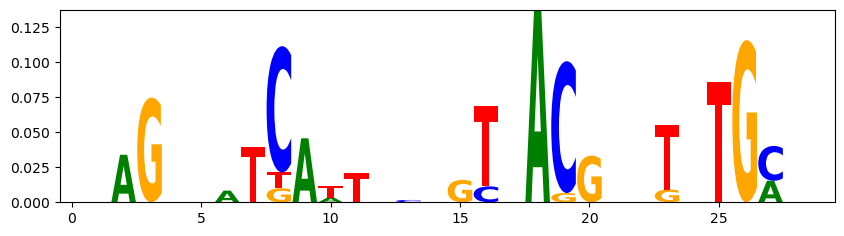

In [54]:
# logomakerを用いてモチーフを可視化
base_df = pd.DataFrame(model_l.feature_importances_.reshape(n*2,4))
base_df.columns = ['A','T','G','C']
crp_logo = logomaker.Logo(base_df, shade_below=.5, fade_below=.5)

In [55]:
existent_intron_combinations

[Seq('GTAGGTTTAAGAACATCTTTTGTGTCGCAG'),
 Seq('GTAAAGTAAAACAACTATGCTTCTTTTCAG'),
 Seq('GTAAAGTAAAACAACCACTTGATTATACAG'),
 Seq('GTAAAGTAAAACAACGTTTTTCTATTTTAG'),
 Seq('GTAAAGCCCATCTTGCACTTGATTATACAG'),
 Seq('GTAAAGCCCATCTTGGTTTTTCTATTTTAG'),
 Seq('GTTAATTGATTTTTAGTTTTTCTATTTTAG'),
 Seq('GTATTGTTATAATGGTTTTTTTTTTTCCAG'),
 Seq('GTATTGTTATAATGGTTTTTCCCCATACAG'),
 Seq('GTATTGTTATAATGGTACTTCCCTTTGCAG'),
 Seq('GTTGGATTTTAAGGATACTTCCCTTTGCAG'),
 Seq('GTAAATGCCATACATAAATTTCTTTTGCAG'),
 Seq('GTAAATGCCATACATTCATATTCTTTTAAG'),
 Seq('GTAAGAAACGTGTGAGTAAACTTCATGTAG'),
 Seq('GTTTGTTTACTGAGTTTCATGCTTTTGTAG'),
 Seq('GTTAGTGCTTGAAAATCTTTCCTTAACTAG'),
 Seq('GTTTGTGTAGGAACATTCATACCATTGTAG'),
 Seq('GTTAGTATTTTTAGATTGTGCAACACACAG'),
 Seq('GTTGGCTGGAGACTTATACCCCTTCTTCAG'),
 Seq('GTTTGCATTGTTTTCTCCTTCCTTCCACAG'),
 Seq('GTTTGTGTTCACTTTCCTTTTTTACTGTAG'),
 Seq('GTTAGTGTTGGTTCCTCATTCTTCTGTTAG'),
 Seq('GTTGGTTCAGAACGTCTTTGTTTTCTACAG'),
 Seq('GTTGGTATTGTTCTTTTTTTCATTGAATAG'),
 Seq('GTTGGCAAATTTTATTTTCTTTCACCTCAG'),


<Axes: >

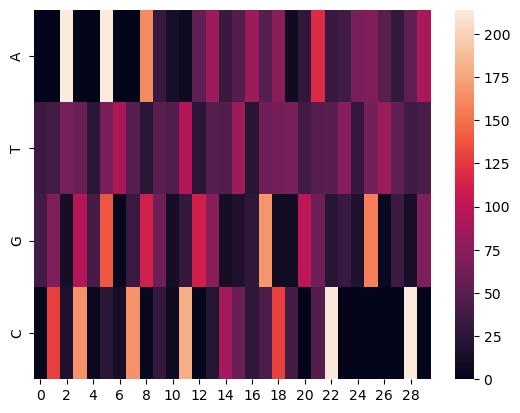

In [58]:
df = pd.DataFrame(encoded_sequences_existent)
pdf = pd.DataFrame(np.array(df.sum()).reshape(4,2*n))
pdf.index = ['A','T','G','C']
sns.heatmap(pdf)

<Axes: >

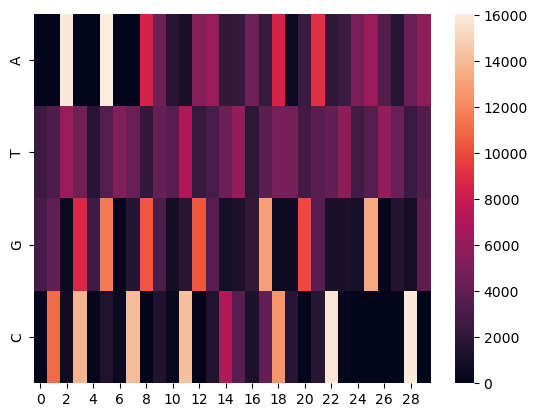

In [60]:
df = pd.DataFrame(encoded_sequences_non_existent)
pdf = pd.DataFrame(np.array(df.sum()).reshape(4,2*n))
pdf.index = ['A','T','G','C']
sns.heatmap(pdf)